In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    """
    Sigmoid activation: 1 / (1 + exp(-x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    result = 1 / (1 + np.exp(-x))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    """
    Derivative of sigmoid: sigmoid(x) * (1 - sigmoid(x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    s = sigmoid(x)
    result = s * (1 - s)
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0, 0.25]"
    return result      

In [59]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Initialise le réseau avec les tailles de couches et les paramètres Adam
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.weights = []
        self.biases = []
        self.m_weights = []
        self.v_weights = []
        self.m_biases = []
        self.v_biases = []

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)
            self.m_weights.append(np.zeros_like(w))
            self.v_weights.append(np.zeros_like(w))
            self.m_biases.append(np.zeros_like(b))
            self.v_biases.append(np.zeros_like(b))

    def forward(self, X):
        """
        Propagation avant : Z[l] = A[l-1]W[l] + b[l], A[l] = g(Z[l])
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{i+1} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        """
        Fonction de perte : entropie croisee binaire
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"
        
        epsilon = 1e-8
        loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        """
        Calcule la précision
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = (y_pred >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        """
        Rétropropagation : calcul des gradients
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = self.activations[-2].T @ dZ / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = self.activations[i].T @ dZ / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        lambda_reg = 0.01
        for i in range(len(self.weights)):
            self.d_weights[i] += lambda_reg * self.weights[i] / m

    def update_parameters_adam(self, t):
        """
        Mise à jour des poids avec Adam
        """
        for i in range(len(self.weights)):
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)

            m_hat_w = self.m_weights[i] / (1 - self.beta1 ** t)
            v_hat_w = self.v_weights[i] / (1 - self.beta2 ** t)
            self.weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)

            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)

            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** t)
            self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Entraînement avec descente de gradient mini-lots et Adam
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        t = 0
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                outputs = self.forward(X_batch)
                self.backward(X_batch, y_batch, outputs)
                t += 1
                self.update_parameters_adam(t)

            y_train_pred = self.forward(X)
            y_val_pred = self.forward(X_val)

            train_loss = self.compute_loss(y, y_train_pred)
            val_loss = self.compute_loss(y_val, y_val_pred)
            train_accuracy = self.compute_accuracy(y, y_train_pred)
            val_accuracy = self.compute_accuracy(y_val, y_val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Prédiction des étiquettes (0 ou 1)
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        probs = self.forward(X)
        predictions = (probs >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions

Epoch 0, Train Loss: 0.5264, Val Loss: 0.5079, Train Acc: 0.7326, Val Acc: 0.7727
Epoch 10, Train Loss: 0.3963, Val Loss: 0.4401, Train Acc: 0.8348, Val Acc: 0.7792
Epoch 20, Train Loss: 0.3527, Val Loss: 0.4400, Train Acc: 0.8500, Val Acc: 0.7922
Epoch 30, Train Loss: 0.3203, Val Loss: 0.4494, Train Acc: 0.8696, Val Acc: 0.7597
Epoch 40, Train Loss: 0.3035, Val Loss: 0.4939, Train Acc: 0.8696, Val Acc: 0.7403
Epoch 50, Train Loss: 0.2884, Val Loss: 0.5493, Train Acc: 0.8783, Val Acc: 0.7468
Epoch 60, Train Loss: 0.2586, Val Loss: 0.5959, Train Acc: 0.9022, Val Acc: 0.7403
Epoch 70, Train Loss: 0.2370, Val Loss: 0.6417, Train Acc: 0.9109, Val Acc: 0.7532
Epoch 80, Train Loss: 0.2185, Val Loss: 0.7145, Train Acc: 0.9152, Val Acc: 0.7468
Epoch 90, Train Loss: 0.1997, Val Loss: 0.7286, Train Acc: 0.9217, Val Acc: 0.7597

Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       100
           1       0.5

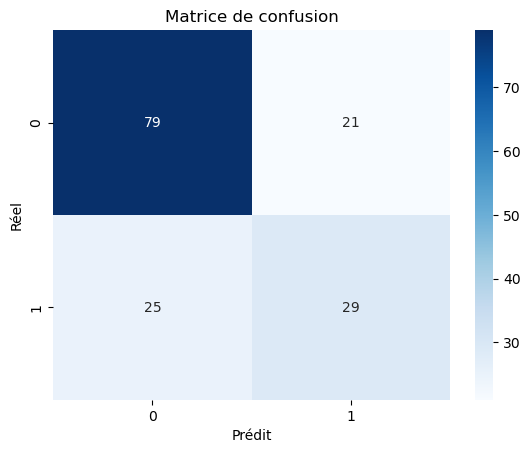

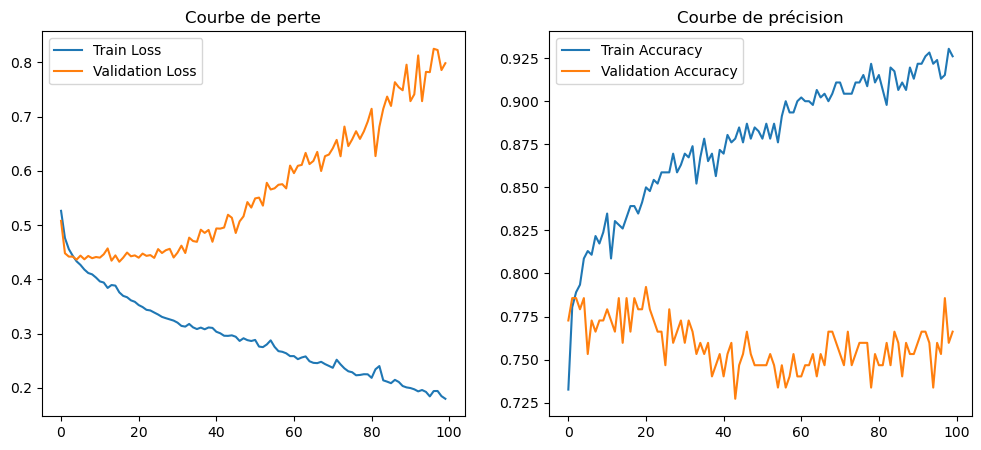

In [63]:
data = pd.read_csv("C:/Users/LUCEOM/Desktop/Master IAA/S2/diabetes.csv")
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data[col].fillna(data[col].median())

X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1)

assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"

# Standardisation
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split en entraînement (80 %) et test (20 %), puis split val (0.25 de 80 %)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0]

# -----------------------------
# Implémentation et entraînement du réseau
# -----------------------------
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# -----------------------------
# Évaluation
# -----------------------------
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# Courbes de perte et de précision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Courbe de précision')
ax2.legend()
plt.show()